In [1]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import math
from pylab import *
import cv2
from scipy.ndimage.filters import maximum_filter

In [2]:
# функция, делающая преобразование картинки x*=x, y*=y-ax^2 
# на вход подается картинка и значение "а"
# преобразование делается при вершине параболы в центре картинки(а не сбоку), т.к. в этом случае коэффициент "b" ищется проще
# т.е нам достаточно искать его на отрезке [-1,1] а не например на [0,100]

def parabol_c(img, a):
    center = np.around(img.shape[1]/2)
    res = img.copy()
    for i in range(img.shape[1]):
        shift = int(np.around(a*(i-center)*(i-center)))
        res[:,i] = np.roll(res[:,i], shift, axis=0)
    return res[:,1:], int(np.around(img.shape[0] + a*center*center))+50

In [3]:
# функция, находящая горизонталь с максимальным значением и само значение

def find_max(img):
    max_ = 0
    argmax = 0
    for i in range(img.shape[0]):
        if img[i-1:i+2,:].sum() > max_ :
            max_ = img[i-1:i+2,:].sum()
            argmax = i
    return max_, argmax

In [4]:
def find_max_multi(img):
    max_ = []
    argmax_ = []
    for i in range(img.shape[0]):
#         if img[i-1:i+2,:].sum() > max_ :
        max1 = img[i-1:i+2,:].sum()
        argmax = i
        max_.append(max1)
        argmax_.append(argmax)
        
    arm = []
    ma = []
    
    for k in range(3):
        ma.append(max(max_))
        arm.append(argmax_[max_.index(max(max_))])
        j = max_.index(max(max_))
        max_.remove(max(max_))
        argmax_.remove(argmax_[j])

    
    
    
    return ma, arm

In [5]:
# функция, находящая коэффициент "b" так: x*=x, *y=y-bx 
# img-картинка, ищем нужное  значение "b" на отрезке [a,b], num - количество разбиений отрезка
# на выходе получаем значение "b" и значение "c"(не совсем)

def find_angle(img, a, b, num):
    m = []
    am = []
    iteration = 0
    new = img.copy()
    db = (b-a)/num
    for i in range(new.shape[1]):
        new[:,i] = np.roll(new[:,i], -int(a*i), axis=0)
    while iteration <= num:
        prob = new.copy()
        for i in range(prob.shape[1]):
            prob[:,i] = np.roll(prob[:,i], -int(i*iteration*db), axis=0)
        maximum, argmaximum = find_max(prob)
        m.append(maximum)
        am.append(argmaximum)
        iteration +=1
    return max(m), am[m.index(max(m))], -(db*(m.index(max(m)))+a)

In [6]:
# другая функция, находящая коэффициент "b" так: x*=x, *y=y-b(x-center) 
# img-картинка, ищем нужное  значение "b" на отрезке [a,b], num - количество разбиений отрезка
# на выходе получаем значение "b" и значение "c"

def find_angle_c(img, a, b, num):
    m = []
    am = []
    iteration = 0
    r = int(img.shape[1]/2)
    
    
    new = img.copy()
    db = (b-a)/num
    for i in range(new.shape[1]):
        new[:,i] = np.roll(new[:,i], -int(a*(i-r)), axis=0)
    while iteration <= num:
        prob = new.copy()
        for i in range(prob.shape[1]):
            prob[:,i] = np.roll(prob[:,i], -int((i-r)*iteration*db), axis=0)
        maximum, argmaximum = find_max(prob)
        m.append(maximum)
        am.append(argmaximum)
        iteration +=1
    return max(m), am[m.index(max(m))], -(db*(m.index(max(m)))+a)

In [7]:
def find_angle_multi(img, a, b, num):
    m = []
    am = []
    iteration = 0
    r = int(img.shape[1]/2)
    
    
    new = img.copy()
    db = (b-a)/num
    for i in range(new.shape[1]):
        new[:,i] = np.roll(new[:,i], -int(a*(i-r)), axis=0)
    while iteration <= num:
        prob = new.copy()
        for i in range(prob.shape[1]):
            prob[:,i] = np.roll(prob[:,i], -int((i-r)*iteration*db), axis=0)
        maximum, argmaximum = find_max_multi(prob)
        m.extend(maximum)
        am.extend(argmaximum)
        iteration +=1
        
    arm = []
    ma = []
    bet = []
    
    for k in range(3):
        ma.append(max(m))
        arm.append(am[m.index(max(m))])
        j = m.index(max(m))
        bet.append(-(db*math.floor(j/3)+a))
        m.remove(max(m))
        am.remove(am[j])
        
    return ma, arm, bet

In [8]:
# отрисовывает на картинке параболу с найденными коэффициэнтами и возращает эту картинку
# т.к предполагается что вершина параболы в центре, то r-значение центра картинки

def draw_parabol(img, a, b, c):
    r = np.around(img.shape[1]/2)
    cimg = cv2.cvtColor(img,cv2.COLOR_GRAY2BGR)
    for i in range(cimg.shape[1]-2):
        if math.fmod(i,2) == 0:
            cv2.line(cimg,(i,int(-a*(i-r)*(i-r) - b*(i-r)+c-b*r)),(i+2,int(-a*(i-r+2)*(i-r+2) - b*(i-r)+c-b*r)),(255,0,0),2)
    
    plt.imshow(cimg)
    plt.xticks([]), plt.yticks([])  
    plt.show()
    return cimg

In [9]:
# новая функция отрисовки параболы

def draw_parabol_c(img, a, b, c):
    r = np.around(img.shape[1]/2)
    if img[0][0].shape == ():
        cimg = cv2.cvtColor(img,cv2.COLOR_GRAY2BGR)
    else:
        cimg = img.copy()
    for i in range(cimg.shape[1]-2):
        if math.fmod(i,2) == 0:
            cv2.line(cimg,(i,int(-a*(i-r)*(i-r) - b*(i-r)+c+50)),(i+2,int(-a*(i-r+2)*(i-r+2) - b*(i-r)+c+50)),(255,0,0),2)
    
#     plt.imshow(cimg)
#     plt.xticks([]), plt.yticks([])  
#     plt.show()
    return cimg

In [10]:
# отрисовывает на картинке разметку эксперта для верхнего затенения и возвращает полученную картинку
# arr - координаты точек ломанной линии

def draw_brokenline(img, arr):
    if img[0][0].shape == ():
        cimg = cv2.cvtColor(img,cv2.COLOR_GRAY2BGR)
    else:
        cimg = img.copy()
    for point in range(int(len(arr)/2 -2)):
        if arr[2*point+2] != 0:
            cv2.line(cimg,(arr[2*point],arr[2*point+1]),(arr[2*point+2],arr[2*point+3]),(0,255,0),2)
    
#     plt.imshow(cimg)
#     plt.xticks([]), plt.yticks([]) 
#     plt.show()
    return cimg

In [11]:
def main2_multi(img, alpha, beta, num_a, num_b):
    top = img[50:]
    
#     plt.imshow(cimg)
#     plt.xticks([]), plt.yticks([]) 
#     plt.show()
    
    a=[]
    m_=[]
    am_=[]
    b_=[]
    a_raw = np.linspace(alpha[0], alpha[1], num_a)
    for item in a_raw:
        new = top.copy()
        new, q = parabol_c(new, item)
        new = new[:-50]
        
        m, am, b= find_angle_multi(new, beta[0], beta[1], num_b)
        a.extend([item, item, item])
        m_.extend(m)
        am_.extend(am)
        b_.extend(b)
     
    arm = []
    ma = []
    bet = []
    al = []
    
    for k in range(3):
        ma.append(max(m_))
        arm.append(am_[m_.index(max(m_))])
        bet.append(b_[m_.index(max(m_))])
        al.append(a[m_.index(max(m_))])
                    
        j = m_.index(max(m_))
                    
        m_.remove(max(m_))
        am_.remove(am_[j])
        b_.remove(b_[j])
        a.remove(a[j])
        
        
        
    return ma, arm, al, bet

In [12]:
# новая главная функция, работающая с новым поиском "b"

def main2(img, alpha, beta, num_a, num_b):
    top = img[50:]
    
#     plt.imshow(cimg)
#     plt.xticks([]), plt.yticks([]) 
#     plt.show()
    
    a=[]
    m_=[]
    am_=[]
    b_=[]
    a_raw = np.linspace(alpha[0], alpha[1], num_a)
    for item in a_raw:
        new = top.copy()
        new, q = parabol_c(new, item)
        new = new[:-50]
        
        m, am, b= find_angle_c(new, beta[0], beta[1], num_b)
        a.append(item)
        m_.append(m)
        am_.append(am)
        b_.append(b)
    return a[m_.index(max(m_))], b_[m_.index(max(m_))], am_[m_.index(max(m_))]

In [14]:
# главная функция, которая и выдает оптимальные значения  коэффициентов "a", "b" и "c"
# img - картинка, alpha - отрезок, на котором будем искать "a", beta - отрезок, на котором будем искать "b"
# num_a, num_b - количество разбиений отрезка alpha и beta соответственно

def main(img, alpha, beta, num_a, num_b):
    a=[]
    m_=[]
    am_=[]
    b_=[]
    a_raw = np.linspace(alpha[0], alpha[1], num_a)
    for item in a_raw:
        new = img.copy()
        new, q = parabol_c(new, item)
        new = new[:q,:]
        m, am, b= find_angle(new, beta[0], beta[1], num_b)
        a.append(item)
        m_.append(m)
        am_.append(am)
        b_.append(b)
    return a[m_.index(max(m_))], b_[m_.index(max(m_))], am_[m_.index(max(m_))]

In [15]:
def treshold(img, p):
    res = img.copy()
    for i in range(res.shape[0]):
        for j in range(res.shape[1]):
            if res[i][j] > p:
                res[i][j] = 255
            else:
                res[i][j] = 0
    return res
    

In [32]:
# берем информацию из файла

# правые глаза
data = pd.read_csv('casia_ds_Expert.txt', sep=' ', header=None)
data = np.asarray(data)

# левые глаза
data2 = pd.read_csv('iris/casia_ds_Expert.txt', sep=' ', header=None)
data2 = np.asarray(data2)

data3 = pd.read_csv('iris/Ice_SD_allAmerican_parameters.txt', sep=' ', header=None)
data3 = np.asarray(data3)

path = 'iris/casia_ds/'
path2 = 'iris/Ice_S/'
path3 = 'iris/Ice_D/'

# используемый фильтр
f_dy = np.array([[1.,2.,1.],
                 [0.,0.,0.],
                 [-1.,-2.,-1.]], dtype = 'float64')

f_dx = np.array([[-1, 0, 1],
                 [-2, 0, 2],
                 [-1, 0, 1]],dtype = 'float64')

**Пример работы на одной картинке**

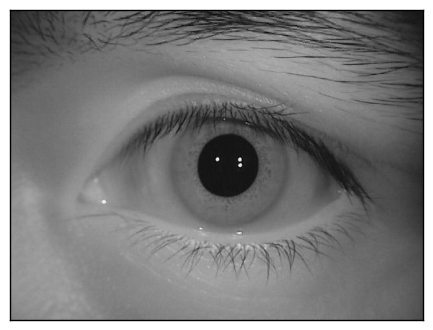

In [41]:
img = cv2.imread(path + data2[0][0] ,0)

plt.imshow(img, cmap = 'gray')
plt.xticks([]), plt.yticks([])  
plt.show()

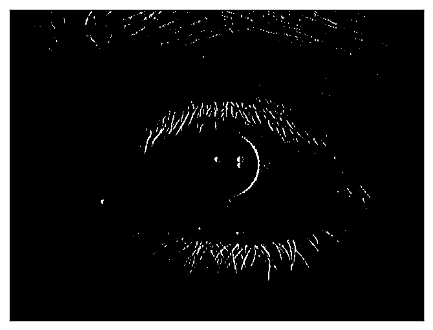

In [27]:
#  пройдемся по картинке градиентным фильтром

grad = cv2.filter2D(img, -1, kernel = f_dx)
res = treshold(grad, 70)
plt.imshow(res, cmap = 'gray')
plt.xticks([]), plt.yticks([]) 
plt.show()



In [80]:

m, c, a, b = main2_multi(grad, (-0.0035, -0.0005), (-0.5,0.5), 40, 40)
print("m=",m)
print("a=",a)
print("b=",b)
print("c=",c)

m= [58257, 56690, 54529]
a= [-0.00050000000000000001, -0.00050000000000000001, -0.00065384615384615373]
b= [0.125, 0.14999999999999997, 0.4]
c= [30, 34, 90]


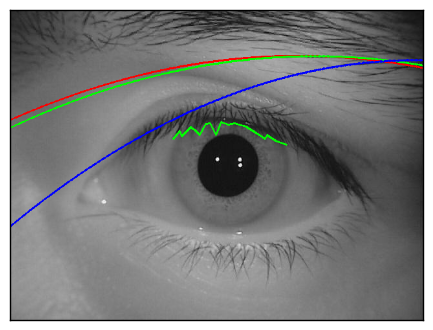

In [81]:
color = [(255,0,0),(0,255,0),(0,0,255)]


for i in range(3):
    img = draw_parabol_c(img, a[i],b[i],c[i], color[i])
    
img = draw_brokenline(img, data2[0][56:96])

In [42]:
img = cv2.imread(path + data[0][0] ,0)
grad = cv2.filter2D(img, -1, kernel = f_dy)
grad2 = cv2.filter2D(img, -1, kernel = f_dx)
a, b, c = main2(grad, (-0.0035, -0.0005), (-0.5,0.5), 40, 40)
print("a=",a)
print("b=",b)
print("c=",c)

a= -0.00203846153846
b= 0.19999999999999996
c= 120


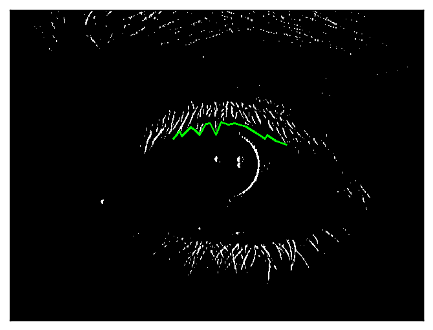

In [34]:
# res = draw_parabol_c(grad2, a,b,c)
grad = cv2.filter2D(img, -1, kernel = f_dx)
res = treshold(grad, 65)
res = draw_brokenline(res, data2[0][56:96])
plt.imshow(res, cmap = 'gray')
plt.xticks([]), plt.yticks([]) 
plt.show()

In [38]:
par_r = pd.read_csv("R_params2.csv")
par_r = np.asarray(par_r)
par_l = pd.read_csv("L_params2.csv")
par_l = np.asarray(par_l)

for item in par_r:
    a,b,c = item[3], item[4], item[5]
    img = cv2.imread(path + data[item[2]][0] ,0)
    grad = cv2.filter2D(img, -1, kernel = f_dx)
    res = treshold(grad, 65)
    res = draw_brokenline(res, data[item[2]][56:96])
    res = draw_parabol_c(res, a,b,c)
    cv2.imwrite('iris_results/'+data[item[2]][0], res)
    print(item[0])
    


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149


In [45]:
#записываем в папку полученные картинки, тут только по одной картинке для каждого глаза (для одной из семи)

i = 0
j = 0
params = np.zeros((1,5))
while i <= data3.shape[0]:
    if (data3[i][0][0] == '7'):
        img = cv2.imread(path2 + data3[i][0] ,0)
    else:
        img = cv2.imread(path3 + data3[i][0] ,0)
        
    grad = cv2.filter2D(img, -1, kernel = f_dy)
    a, b, c = main2(grad, (-0.0035, -0.0005), (-0.5,0.5), 40, 40)
    img = draw_parabol_c(img, a,b,c)
    img = draw_brokenline(img, data3[i][56:96])
    cv2.imwrite('iris_results/'+data3[i][0], img)
    z = np.array([data3[i][0], i, a, b, c]).reshape((1,5))
    params = np.concatenate((params, z), axis=0)
    i +=10
    j +=1
    print(j,i)




1 10
2 20
3 30
4 40
5 50
6 60
7 70
8 80
9 90
10 100
11 110
12 120
13 130
14 140
15 150
16 160
17 170
18 180
19 190
20 200
21 210
22 220
23 230
24 240
25 250
26 260
27 270
28 280
29 290
30 300
31 310
32 320
33 330
34 340
35 350
36 360
37 370
38 380
39 390
40 400
41 410
42 420
43 430
44 440
45 450
46 460
47 470
48 480
49 490
50 500
51 510
52 520
53 530
54 540
55 550
56 560
57 570
58 580
59 590
60 600
61 610
62 620
63 630
64 640
65 650
66 660
67 670
68 680
69 690
70 700
71 710
72 720
73 730
74 740
75 750
76 760
77 770
78 780
79 790
80 800
81 810
82 820
83 830
84 840
85 850
86 860
87 870
88 880
89 890
90 900
91 910
92 920
93 930
94 940
95 950
96 960
97 970
98 980
99 990
100 1000
101 1010
102 1020
103 1030
104 1040
105 1050
106 1060
107 1070
108 1080
109 1090
110 1100
111 1110
112 1120
113 1130
114 1140
115 1150
116 1160
117 1170
118 1180
119 1190
120 1200
121 1210
122 1220
123 1230
124 1240
125 1250
126 1260
127 1270
128 1280
129 1290
130 1300
131 1310
132 1320
133 1330
134 1340
135 1350
1

In [69]:
# функцияя для ошибок Е1 и Е2

def error_rate(f, arr):
    e1 = 0
    e2 = 0
    i = 0 
    bl = 1
    while i < int(len(arr)/2)-1:
        point1 = arr[2*i:2*i+2]
        point2 = arr[2*i+2: 2*i+4]
        if point2[0] == 0:
            break
        if point2[0] == point1[0]:
            point1 = point2
            point2 = arr[2*i+4: 2*i+6]
            i += 1
        if point2[0] > point1[0]:
            k = (point2[1] - point1[1])/(point2[0] - point1[0])
            for j in range(point1[0], point2[0]):
                razm = point1[1] + k*(j-point1[0])
                par = f(j)
                if razm > par:
                    e1 += razm-par
                else:
                    e2 +=par-razm
        else:
            k = (point2[1] - point1[1])/(point1[0] - point2[0])
            for j in range(point2[0], point1[0]):
                razm = point1[1] + k*(point1[0]-j)
                par = f(j)
                if razm > par:
                    e1 -= razm-par
                else:
                    e2 -= par-razm
        i += 1
        
    t = []
    for p in range(len(arr)):
        if (math.fmod(p,2) == 0) and (arr[p] != 0):
            t.append(p)
            
    return e1/(max(t)-min(t)), e2/(max(t)-min(t))

In [71]:
def error_rate2(f, x, y, r, arr):
    e1 = 0
    e2 = 0
    i = 0 
    cir = lambda x_: -np.sqrt(r**2 - (x_ - x)**2) + y
    
    if(x-r < arr[0]):
        for j in range(x-r+1, arr[0]):
            par = f(j)
            c = cir(j)
            if(par > c):
                e2 += par - c
    
    while i < int(len(arr)/2)-1:
        point1 = arr[2*i:2*i+2]
        point2 = arr[2*i+2: 2*i+4]
        if point2[0] == 0:
            if(x+r > point1[0]):
                for j in range(point1[0], x+r-1):
                    par = f(j)
                    c = cir(j)
                    if(par > c):
                        e2 += par - c   
            break
        if point2[0] == point1[0]:
            point1 = point2
            point2 = arr[2*i+4: 2*i+6]
            i += 1
        if point2[0] > point1[0]:
            k = (point2[1] - point1[1])/(point2[0] - point1[0])
            for j in range(point1[0], point2[0]):
                if(j >= x-r) and (j <= x+r):
                    razm = point1[1] + k*(j-point1[0])
                    par = f(j)
                    c = cir(j)
                    
                    if razm > par:
                        m = max(par,c)
                        if(razm > m):
                            e1 += razm-m
                    else:
                        m = max(razm,c)
                        if(par > m):
                            e2 +=par-m
        else:
            k = (point2[1] - point1[1])/(point1[0] - point2[0])
            for j in range(point2[0], point1[0]):
                if(j >= x-r) and (j <= x+r):
                    razm = point1[1] + k*(point1[0]-j)
                    par = f(j)
                    c = cir(j)
                    if razm > par:
                        m = max(par,c)
                        if(razm > m):
                            e1 -= razm-m
                    else:
                        m = max(razm,c)
                        if(par > m):
                            e2 -= par-m
        i += 1
        
#     t = []
#     for p in range(len(arr)):
#         if (math.fmod(p,2) == 0) and (arr[p] != 0):
#             t.append(p) 
    
    return e1, e2

In [106]:
a,b,c = par_r[0][3], par_r[0][4], par_r[0][5]
print(a,b,c)
function = lambda x: (-a*(x-320)*(x-320) - b*(x-320)+c+50+13)

-0.00157692307692 0.2 138


In [76]:
par_r = pd.read_csv("R_params2.csv") # 2700, 2900
par_r = np.asarray(par_r)
par_l = pd.read_csv("L_params2.csv") # 0, 1460
par_l = np.asarray(par_l)
Ice_par = pd.read_csv('Ice_params.csv') # 70, 1000
Ice_par = np.asarray(Ice_par)

qq=[]
e1_mean=[]
e2_mean=[]

for q in range(81):
    i = 0
    j = 0
    error1 = []
    error2 = []
    while i < 3000 :
        #img = cv2.imread(path + data[i][0] ,0)
        #grad = cv2.filter2D(img, -1, kernel = f_dy)
        #a, b, c = main(grad, (-0.003, -0.001), (-1,1), 20, 40)
        if (i != 2700) and (i != 2900):
            a = par_r[j][3]
            b = par_r[j][4]
            c = par_r[j][5]
            function = lambda x: (-a*(x-320)*(x-320) - b*(x-320)+c+50+q)
            e1, e2 = error_rate2(function, data[i][11], data[i][12], data[i][13], data[i][56:96])
            sq = np.pi*(data[i][13]**2 - data[i][8]**2)
            error1.append(e1/sq)
            error2.append(e2/sq)
        i +=20
        j +=1
    i = 0
    j = 0
    while i < 3000 :
        #img = cv2.imread(path + data[i][0] ,0)
        #grad = cv2.filter2D(img, -1, kernel = f_dy)
        #a, b, c = main(grad, (-0.003, -0.001), (-1,1), 20, 40)
        if (i != 0) and (i != 1460):
            a = par_l[j][3]
            b = par_l[j][4]
            c = par_l[j][5]
            function = lambda x: (-a*(x-320)*(x-320) - b*(x-320)+c+50+q)
            e1, e2 = error_rate2(function, data2[i][11], data2[i][12], data2[i][13], data2[i][56:96])
            sq = np.pi*(data2[i][13]**2 - data2[i][8]**2)
            error1.append(e1/sq)
            error2.append(e2/sq)
        i +=20
        j +=1
    qq.append(q)
    e1_mean.append(np.mean(error1))
    e2_mean.append(np.mean(error2))
        #print(j,i)

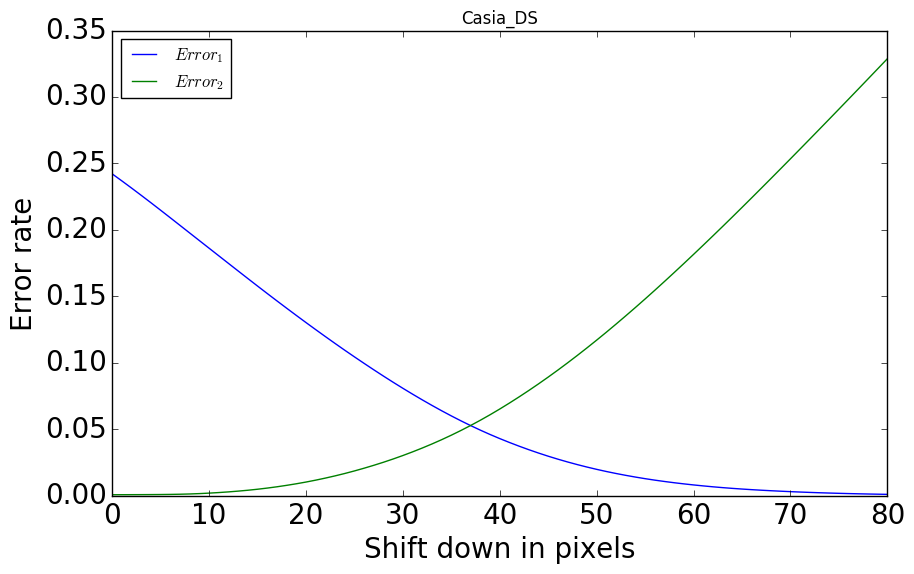

In [78]:
plt.figure(figsize=(10, 6))
plt.plot([x for x in qq], [y for y in e1_mean], label="$Error_1$")
plt.plot([x for x in qq], [y for y in e2_mean], label="$Error_2$")
plt.xlabel(r"Shift down in pixels", fontsize=20)
plt.ylabel(r"Error rate", fontsize=20)
plt.xticks(fontsize = 20)
plt.yticks(fontsize = 20)
plt.title('Casia_DS')
plt.legend(loc="best")
plt.show()

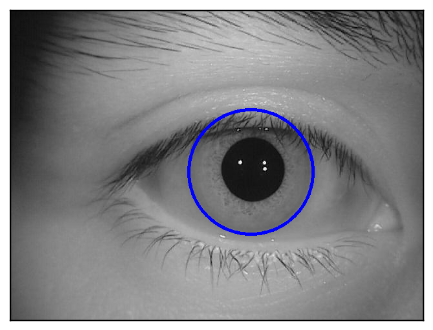

In [29]:
img = cv2.imread(path + data[0][0] ,0)
cimg = cv2.cvtColor(img,cv2.COLOR_GRAY2BGR)
cv2.circle(cimg, (data[0][11],data[0][12]), data[0][13], (0,0,255), 3)

plt.imshow(cimg)
plt.xticks([]), plt.yticks([])  
plt.show()

In [41]:
function = lambda x: np.sqrt((data[0][13])**2 - (x-data[0][11])**2) + data[0][12]

In [24]:
def draw_circle(img, x, y, rad):
    r = np.around(img.shape[1]/2)
    function = lambda x_: np.sqrt(rad**2 - (x_- x)**2) + y
    if img[0][0].shape == ():
        cimg = cv2.cvtColor(img,cv2.COLOR_GRAY2BGR)
    else:
        cimg = img.copy()
    for i in np.arange(x-rad, x+rad):
        if math.fmod(i,2) == 0:
            print(i, rad,  (i- x))
            print(i, function(i))
            cv2.line(cimg,(i,int(function(i))),(i+2,int(function(i+2))),(255,0,0),2)
    
    plt.imshow(cimg)
    plt.xticks([]), plt.yticks([])  
    plt.show()
#     return cimg

In [25]:
draw_circle(img, data[0][11], data[0][12], data[0][13])

NameError: name 'img' is not defined

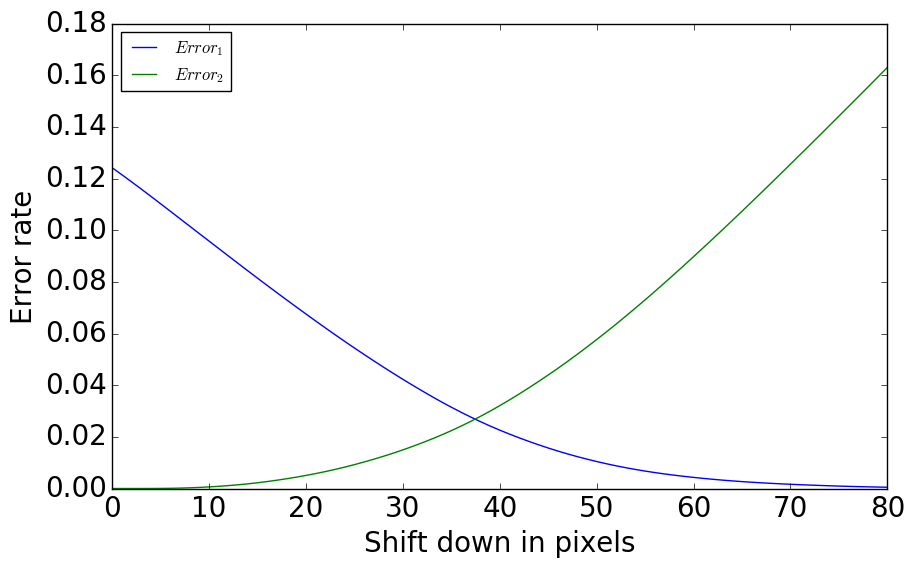

In [21]:
plt.figure(figsize=(10, 6))
plt.plot([x for x in qq], [y for y in e1_mean], label="$Error_1$")
plt.plot([x for x in qq], [y for y in e2_mean], label="$Error_2$")
plt.xlabel(r"Shift down in pixels", fontsize=20)
plt.ylabel(r"Error rate", fontsize=20)
plt.xticks(fontsize = 20)
plt.yticks(fontsize = 20)
plt.legend(loc="best")
plt.show()

**Видим что средняя разница между параболой и разметкой составляет около 70 пикселей**

In [32]:
# i = 0
# j = 0
# params = np.zeros((1,5))
# while i <= data.shape[0]:
#     img = cv2.imread(path + data[i][0] ,0)
#     grad = cv2.filter2D(img, -1, kernel = f_dy)
#     a, b, c = main(grad, (-0.003, -0.001), (-1,1), 20, 40)
#     z = np.array([data[i][0], i, a, b, c]).reshape((1,5))
#     print(params.shape,z.shape)
#     params = np.concatenate((params, z), axis=0)
    
#     i +=20
#     j +=1
#     print(j,i)

In [14]:
# par1 = pd.read_csv('params.csv')
# par2 = pd.read_csv('params2.csv')

In [70]:
# def find_angle2(img, a, b, num):
#     r = int(img.shape[1]/2)
#     m = []
#     am = []
#     iteration = 0
#     new = img.copy()
#     db = (b-a)/num
#     print('received', new.shape)
#     plt.imshow(new, cmap = 'gray')
#     plt.xticks([]), plt.yticks([])  # to hide tick values on X and Y axis
#     plt.show()
#     for i in range(new.shape[1]):
#         new[:,i] = np.roll(new[:,i], -int((i-r)*a), axis=0)
        
#     print('changed',new.shape )
#     plt.imshow(new, cmap = 'gray')
#     plt.xticks([]), plt.yticks([])  # to hide tick values on X and Y axis
#     plt.show()
#     while iteration <= num:
#         prob = new.copy()
#         for i in range(prob.shape[1]):
#             prob[:,i] = np.roll(prob[:,i], -int((i-r)*iteration*db), axis=0)
#         maximum, argmaximum = find_max(prob)
#         m.append(maximum)
#         am.append(argmaximum)
        
#         z = db*iteration + a
#         print(z, argmaximum, maximum)
        
#         plt.figure(figsize=(10,8))
#         subplot(121)
#         plt.imshow(prob, cmap = 'gray')
#         #plt.title('beta = ',z)
#         plt.xticks([]), plt.yticks([])  # to hide tick values on X and Y axis
        
#         subplot(122)
#         prob2 = cv2.cvtColor(prob,cv2.COLOR_GRAY2BGR)
#         cv2.line(prob2,(0,argmaximum),(prob2.shape[1]-1,argmaximum),(255,0,0),2)
#         plt.imshow(prob2)
#         #plt.title('beta = ',z)
#         plt.xticks([]), plt.yticks([])  # to hide tick values on X and Y axis
        
#         plt.show()
#         iteration +=1
        
#     beta = -(db*(m.index(max(m)))+a)
    
#     return m, am, beta

In [206]:
# img = cv2.imread(path + data2[73*20][0] ,0)
# g = cv2.filter2D(img, -1, kernel = f_dy)
# p, q = parabol_c(g, -0.00119230769231)
# plt.imshow(p[50:-50], cmap = 'gray')
# plt.xticks([]), plt.yticks([])  # to hide tick values on X and Y axis
# plt.show()
# find_angle2(p[50:-50], -0.5, 0.5, 40)

In [85]:
def dpc(img, a, b, c, color):
    r = np.around(img.shape[1]/2)
    if img[0][0].shape == ():
        cimg = cv2.cvtColor(img,cv2.COLOR_GRAY2BGR)
    else:
        cimg = img.copy()
        
    for i in range(cimg.shape[1]-2):
        if math.fmod(i,2) == 0:
            cv2.line(cimg,(i,int(-a*(i-r)*(i-r) - b*(i-r)+c+50)),(i+2,int(-a*(i-r+2)*(i-r+2) - b*(i-r)+c+50)),color,2)
    
    plt.imshow(cimg)
    plt.xticks([]), plt.yticks([])  
    plt.show()


In [2301]:
params = np.zeros((1,5))

In [4153]:
i = 150
img = cv2.imread(path + data2[i*20][0] ,0)
img2 = draw_brokenline(img, data2[i*20][56:96])

TypeError: 'NoneType' object is not subscriptable

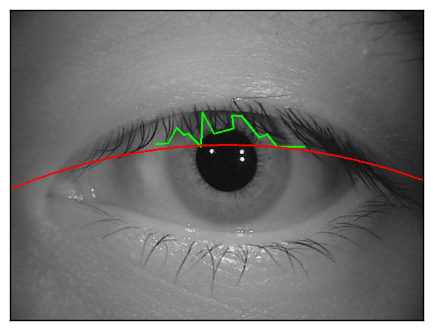

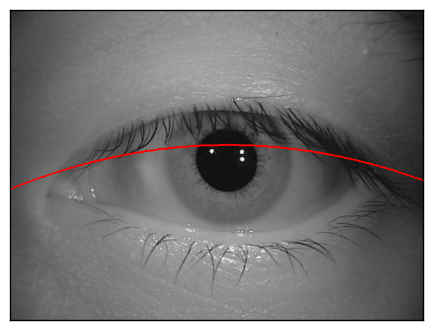

In [4149]:
a= -0.0006
b= 0.02
c= 160

dpc(img2, a, b, c, (255,0,0))
dpc(img, a, b, c, (255,0,0))

In [4150]:
img = draw_parabol_c(img, a,b,c, (255,0,0))
img = draw_brokenline(img, data2[i*20][56:96])
cv2.imwrite('iris_results/'+data2[i*20][0], img)

True

In [4151]:
z = np.array([data2[i*20][0], i*20, a, b, c]).reshape((1,5))
params = np.concatenate((params, z), axis=0)

In [4155]:
xx = pd.DataFrame(x)
xx.to_csv('Expert_L.csv')